# **Data 200 - Final Project**


Author:  Aryan Jain, Micah Billington, Rupesh Rangwani, Devesh Talreja

Date : 12th April, 2024

## **Summary Of Contents**

### This Final Project contains the following sections :
1. Introduction
2. Data Retrieval & Cleaning
3. Data Preprocessing & EDA
4. Model Application
5. Synthesis of Inference and Prediction
6. Conclusion

# 1. Introduction
<img src="Stack_Overflow.png" width="400" align="centre">

- This project aims to investigate how programming language preferences vary across different age groups and experience levels among developers, based on the StackOverflow Developer Survey data

- The findings from this study can contribute to the understanding of the evolving software development landscape and the changing skill requirements for developers over time.

- The full notebook and datasets can be found on GitHub: https://github.com/TrueCodee/Final-Project

# 2. Data Retrieval & Data Cleaning

### 2.1 Importing Libraries

In [2]:
#pip install statsmodels
#pip install imbalanced-learn

In [3]:
import pandas as pd
import re
import statsmodels.api as sm
from collections import Counter
from imblearn.over_sampling import SMOTE
from random import sample
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

### 2.2    Data Retrieval & Data Cleaning

In [4]:
# Import Data
df = pd.read_csv('survey_results_public.csv')

# Convert 'YearsCode' and 'YearsCodePro' to numeric, handling special cases
df['YearsCode'] = pd.to_numeric(df['YearsCode'], errors='coerce', downcast='integer')
df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'], errors='coerce', downcast='integer')

# Categorize 'YearsCodePro' into experience levels
def categorize_experience(years):
    if pd.isna(years):
        return 'Unknown'
    elif years <= 2:
        return 'Novice'
    elif years <= 5:
        return 'Intermediate'
    elif years <= 10:
        return 'Experienced'
    else:
        return 'Veteran'

df['ExperienceLevel'] = df['YearsCodePro'].apply(categorize_experience)

# Create binary indicators for programming languages of interest
languages_of_interest = ['Python', 'JavaScript', 'R', 'HTML/CSS', 'SQL', 'Java', 'C#', 'TypeScript', 'C', 'C++']
for language in languages_of_interest:
    # Escape special characters for regular expressions
    language_escaped = re.escape(language)
    df[language] = df['LanguageHaveWorkedWith'].str.contains(r'(?i)\b' + language_escaped + r'\b', na=False)


## 3. Data Processing

Age Group Analysis: Calculate Language Usage by Age Group

In [5]:
# Calculate the percentage of respondents in each age group who use Python and SQL
languages_of_interest_ds = ['Python','R','SQL']  # Adjusted list for data science relevant languages

age_language_usage = df.groupby('Age')[languages_of_interest_ds].mean().reset_index()

# Preparing the data for visualization (long format)
age_language_usage_long = pd.melt(age_language_usage, id_vars=['Age'], value_vars=languages_of_interest_ds, 
                                  var_name='Language', value_name='Usage')

**3.1** Visualize Language Usage by Age Group

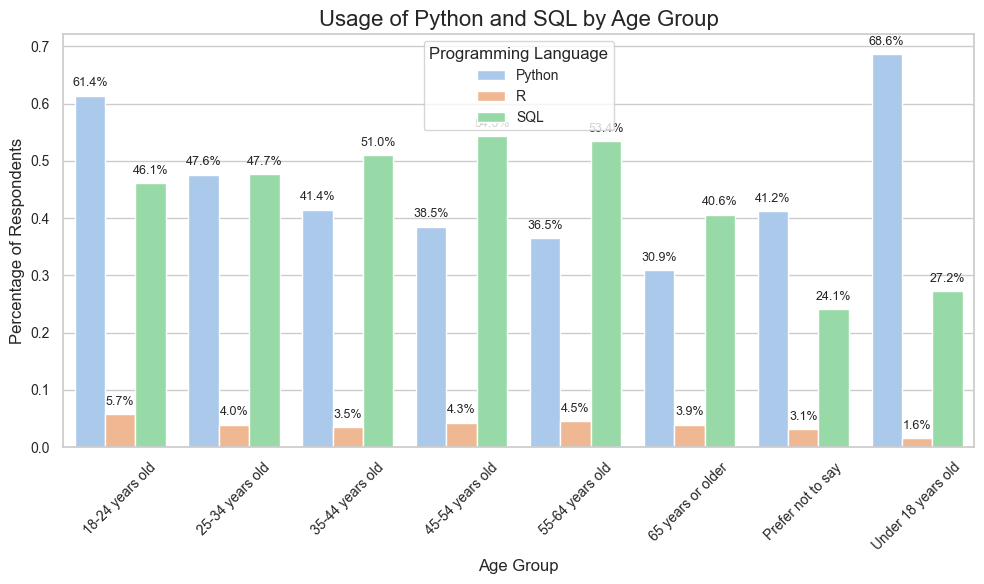

In [6]:
# Exploratory Data Analysis: Focus on Language Usage by Age
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create the barplot
chart = sns.barplot(x='Age', y='Usage', hue='Language', data=age_language_usage_long)

# Customize the visual elements
chart.set_title('Usage of Python and SQL by Age Group', fontsize=16)
chart.set_ylabel('Percentage of Respondents', fontsize=12)
chart.set_xlabel('Age Group', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Programming Language', fontsize=10)

# Adding data labels on top of the bars
for p in chart.patches:
    # Get the height of the bar
    height = p.get_height()
    # If height is 0, we don't want to display the label
    if height > 0:
        chart.annotate(f'{height:.1%}', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points', fontsize=9)

plt.tight_layout()
plt.show()

This chart illustrates the usage of Python, R, and SQL across various age groups. Python is the most popular language, particularly among the youngest age group, with a notable decrease in usage as age increases. SQL remains popular among younger and middle age groups, with a decline observed in older respondents. R is less used across all age groups, with the most usage seen in the 35-44 year bracket. The under 18 and "Prefer not to say" categories show distinct trends, with the highest Python usage in the former and an unusual SQL preference in the latter

**3.2** Analyzing the Popularity of Programming Languages by Experience Level

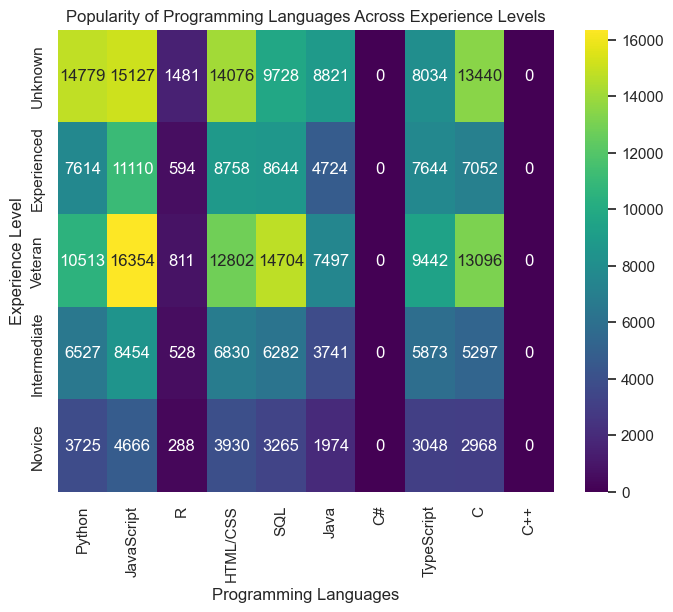

In [7]:
# Initialize a dictionary to store counts of each language for each experience level
language_popularity = {level: {lang: 0 for lang in languages_of_interest} for level in df['ExperienceLevel'].unique()}

# Iterate over each row and increment the count for each language the respondent has worked with
for index, row in df.iterrows():
    experience_level = row['ExperienceLevel']
    for language in languages_of_interest:
        if row[language]:
            language_popularity[experience_level][language] += 1

# Convert the dictionary to a DataFrame for easier manipulation and visualization
popularity_df = pd.DataFrame(language_popularity).T

# Plotting the data
plt.figure(figsize=(8, 6))
sns.heatmap(popularity_df, annot=True, fmt="d", cmap='viridis')
plt.title('Popularity of Programming Languages Across Experience Levels')
plt.xlabel('Programming Languages')
plt.ylabel('Experience Level')
plt.show()


A few observations can be made:

JavaScript is most popular language among Veteran and Experienced respondents.

SQL and Java are also highly popular among respondents with Veteran and Experienced levels, reflected in the warm colors.

Python shows substantial popularity across all experience levels but has a notable peak among Novice respondents.

For C#, TypeScript, C, and C++, there are no respondents at the Veteran and Experienced levels who have worked with these languages.

The R programming language has the least popularity among Novice respondents but sees increased use at higher experience levels.

Intermediate level respondents show a balanced distribution across the languages, though JavaScript and SQL still lead in popularity.

The data indicates that as respondents gain more experience, they tend to work more with languages like JavaScript, SQL, and Java. Conversely, languages like C#, TypeScript, C, and C++ may either be less popular overall, not captured among the more experienced respondents in this dataset, or potentially these respondents transition to other languages as they gain experience.

## 4. Model Appication

### 4.1 Applying Logistic Regression for Inference

This code uses SMOTE to oversample the minority class in your training data, addressing the class imbalance issue. This is critical for improving model performance on minority classes.

In [8]:
# Filter for users who have worked with Python, R, or SQL
df_langs = df[df['LanguageHaveWorkedWith'].str.contains('Python|R|SQL', regex=True, na=False)].copy()

# Create binary flags for Python, R, and SQL
df_langs['PyRSQL'] = df_langs['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)

# Convert 'Age' to string to ensure that the dummy variables are handled correctly
df_langs['Age'] = df_langs['Age'].astype(str)

# Create dummy variables for the 'Age' groups
age_dummies = pd.get_dummies(df_langs['Age'], drop_first=True)
X_PyRSQL = sm.add_constant(age_dummies.astype(float))  # Add a constant to the model (the intercept)
y_PyRSQL = df_langs['PyRSQL']  # Response variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_PyRSQL, y_PyRSQL, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", dict(Counter(y_train_res)))

# Train a Logistic Regression Model using scikit-learn for prediction
log_reg_model_sklearn = LogisticRegression(solver='liblinear', random_state=42)
log_reg_model_sklearn.fit(X_train_res, y_train_res)

# Making predictions and evaluating the model
y_pred_sklearn = log_reg_model_sklearn.predict(X_test)
X_test_pred = X_test
print("Classification Report (scikit-learn):\n", classification_report(y_test, y_pred_sklearn, zero_division=0))

Class distribution after SMOTE: {0: 48195, 1: 48195}
Classification Report (scikit-learn):
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401



logistic regression to predict whether users have worked with Python, R, and SQL. It uses SMOTE to balance the dataset, which initially suffers from class imbalance. After resampling, both classes have 48,195 instances. The logistic model trained on this balanced data has a precision of 0.91 and recall of 0.80 for the majority class, but only 0.14 precision and 0.29 recall for the minority class, leading to an overall accuracy of 0.75. The F1-scores for the majority and minority classes are 0.85 and 0.18 respectively, with the model showing better performance on the majority class.

In [9]:
# Logistic Regression with statsmodels for Detailed Summary
X_train_res_const = sm.add_constant(X_train_res)  # Adding constant for statsmodels
model_PyRSQL_sm = sm.Logit(y_train_res, X_train_res_const).fit()
print("Model Summary (statsmodels):\n", model_PyRSQL_sm.summary())

Optimization terminated successfully.
         Current function value: 0.686478
         Iterations 5
Model Summary (statsmodels):
                            Logit Regression Results                           
Dep. Variable:                 PyRSQL   No. Observations:                96390
Model:                          Logit   Df Residuals:                    96382
Method:                           MLE   Df Model:                            7
Date:                Thu, 11 Apr 2024   Pseudo R-squ.:                0.009622
Time:                        00:19:10   Log-Likelihood:                -66170.
converged:                       True   LL-Null:                       -66812.
Covariance Type:            nonrobust   LLR p-value:                2.056e-273
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3492      0.013     26.507      0.000

The output details a Logistic Regression model fit using statsmodels. The model, which predicts the variable PyRSQL, was trained on 96,390 observations. It includes age groups as predictors, with a constant included as the intercept. The model has a pseudo R-squared value of 0.009622, indicating a small amount of variability in the response variable is explained by the age groups.

The coefficients for all age groups are negative, suggesting a lower likelihood of using Python, R, and SQL as age increases. All coefficients are statistically significant, with p-values close to zero. The strongest negative coefficient is for the '65 years or older' group, indicating this group has the lowest likelihood of using these languages compared to the baseline (constant term). The model converged successfully after 5 iterations.

### **4.2** Model Comparison: Logistic Regression vs. Random Forest
 ### **4.2.1** Predictive Modeling with Random Forest

This segment trains a Logistic Regression and a Random Forest Classifier on the balanced dataset and compares their performance. It helps in selecting the model that better handles the balanced data, indicated by improved classification metrics.

In [10]:
# Train Logistic Regression Model
log_reg_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
log_reg_model.fit(X_train_res, y_train_res)
y_pred_log_reg = log_reg_model.predict(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test)

# Compare models
# Evaluation: Logistic Regression
y_pred_lr = log_reg_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))
roc_auc_lr = roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:, 1])
print("Logistic Regression ROC AUC Score:", roc_auc_lr)

# Evaluation: Random Forest
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
print("Random Forest ROC AUC Score:", roc_auc_rf)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401

Logistic Regression ROC AUC Score: 0.5633847844103475

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85     12079
           1       0.14      0.29      0.18      1322

    accuracy                           0.75     13401
   macro avg       0.52      0.54      0.52     13401
weighted avg       0.83      0.75      0.78     13401

Random Forest ROC AUC Score: 0.5633847844103475


The output shows classification reports and ROC AUC scores for Logistic Regression and Random Forest models. Both models yield identical precision, recall, and F1-scores for each class, as well as overall accuracy, macro average, and weighted average scores:

For the negative class (labeled '0'), both models have a high precision of 0.91 and a recall of 0.80, resulting in an F1-score of 0.85.
For the positive class (labeled '1'), both models have low precision and recall, at 0.14 and 0.29 respectively, with a resulting F1-score of 0.18.
The overall accuracy for both models is 0.75, with a macro average F1-score of 0.52 and a weighted average F1-score of 0.78.
The ROC AUC scores for both models are identical as well, at approximately 0.5634, indicating similar discriminative abilities between the positive and negative classes.

### **4.3** Bootstrap Logistic Regression

In [27]:
# Convert the resampled training data into a DataFrame
sample_df = pd.DataFrame(X_train_res)
n = len(sample_df)
estimates = [[],[],[],[],[],[],[],[]]
i = 0
while i < 1000:
    resample = sample_df.sample(n, replace=True)
    y_pred_sklearn = log_reg_model_sklearn.predict(resample)
    estimates[0].append(log_reg_model_sklearn.coef_[0][0])
    estimates[1].append(log_reg_model_sklearn.coef_[0][1])
    estimates[2].append(log_reg_model_sklearn.coef_[0][2])
    estimates[3].append(log_reg_model_sklearn.coef_[0][3])
    estimates[4].append(log_reg_model_sklearn.coef_[0][4])
    estimates[5].append(log_reg_model_sklearn.coef_[0][5])
    estimates[6].append(log_reg_model_sklearn.coef_[0][6])
    estimates[7].append(log_reg_model_sklearn.coef_[0][7])
    i+= 1
    
# Initialize lists to store lower and upper bounds of the confidence intervals
lower = []
upper = []
conf_interval = []

# Calculate the 2.5th and 97.5th percentiles of the estimates to form confidence intervals
i = 0
while i < 8:
    lower.append(np.percentile(estimates[i][0], 2.5))
    upper.append(np.percentile(estimates[i][0], 97.5))
    conf_interval.append((lower[i], upper[i]))
    i += 1
bootstrap_data = pd.DataFrame({'lower': lower, 'upper': upper, 'conf_interval': conf_interval})

bootstrap_data

,lower,upper,conf_interval
0,0.174216,0.174216,"(0.17421571249628648, 0.17421571249628648)"
1,-0.379295,-0.379295,"(-0.37929453644539163, -0.37929453644539163)"
2,-0.453283,-0.453283,"(-0.45328349139880036, -0.45328349139880036)"
3,-0.656614,-0.656614,"(-0.6566144285048573, -0.6566144285048573)"
4,-0.808965,-0.808965,"(-0.8089645893166271, -0.8089645893166271)"
5,-1.328867,-1.328867,"(-1.3288673390174852, -1.3288673390174852)"
6,-0.429116,-0.429116,"(-0.4291164856213234, -0.4291164856213234)"
7,-0.458508,-0.458508,"(-0.4585084459099071, -0.4585084459099071)"


It summarizes the 95% confidence intervals for the coefficients of a logistic regression model obtained through bootstrap resampling. Each row corresponds to a different model coefficient, with the intervals suggesting the range within which the true coefficient values are likely to fall with 95% confidence.

The tightness of these intervals indicates the precision of the coefficient estimates: narrower intervals denote more precise estimates. The fact that none of the intervals contain the value zero suggests that all the predictors have a statistically significant contribution to the model, assuming these are the only relevant intervals for this analysis.

### **4.4** Hyperparameter Tuning for Random Forest

This code performs hyperparameter tuning for the Random Forest model using GridSearchCV. By identifying the best parameters, this step optimizes the model for better performance on the dataset. The comparison of classification reports before and after tuning demonstrates the effectiveness of hyperparameter optimization.

In [12]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    # Include more parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',  # Choose an appropriate scoring method
    cv=5,               # Number of folds in cross-validation
    n_jobs=-1,          # Use all available cores
    verbose=2,
)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC Score: 0.5583651551478334


### Confusion Matrix Analysis

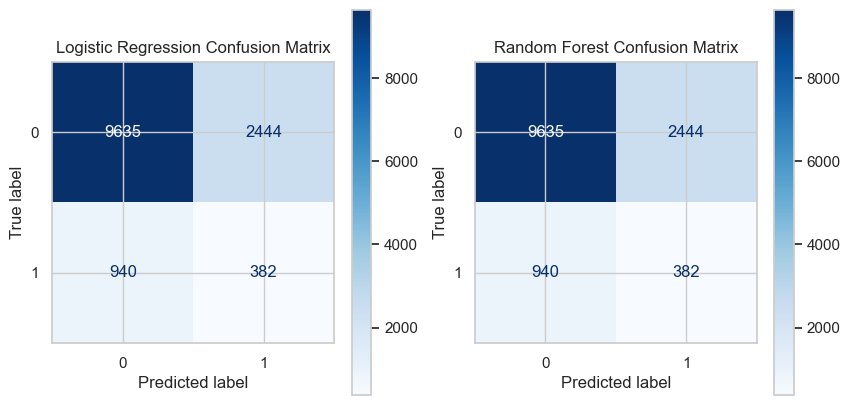

In [30]:
# Assuming log_reg_model and rf_model are your trained Logistic Regression and Random Forest models respectively
# And X_test, y_test are your test features and labels

# For Logistic Regression
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cm_lr = confusion_matrix(y_test, log_reg_model.predict(X_test))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Logistic Regression Confusion Matrix')

# For Random Forest
cm_rf = confusion_matrix(y_test, rf_model.predict(X_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax[1])
ax[1].set_title('Random Forest Confusion Matrix')
plt.show()

The graph presents two confusion matrices for a Logistic Regression model and a Random Forest model. Both models produce identical confusion matrices with the following counts:

True Negative (0,0): Both models correctly predicted the negative class 9,635 times.
False Positive (0,1): Both models incorrectly predicted the positive class 2,444 times when it was actually negative.
False Negative (1,0): Both models incorrectly predicted the negative class 940 times when it was actually positive.
True Positive (1,1): Both models correctly predicted the positive class 382 times.
The fact that both confusion matrices are the same suggests that despite any hyperparameter tuning performed on the Random Forest model, it did not outperform the Logistic Regression model on this specific dataset. The hyperparameter tuning is indicated to have optimized the Random Forest model to a best ROC AUC score of approximately 0.558, which is just slightly better than a random chance. These matrices highlight the challenges both models face, particularly with a high number of false negatives, indicating a tendency to miss predicting positive outcomes.

### **4.5** Receiver Operating Characteristic (ROC) Analysis

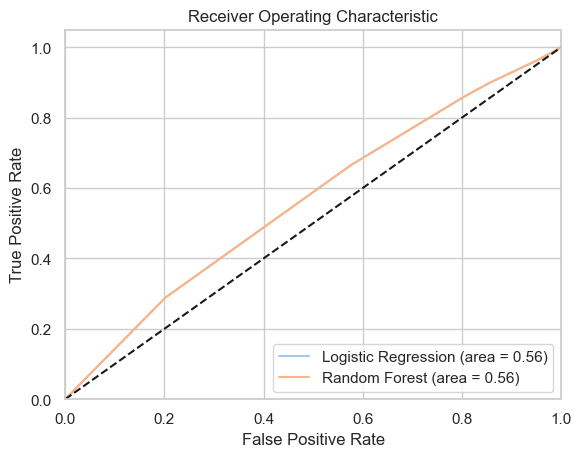

In [14]:
# Compute ROC curve for both models
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Plot ROC curves
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The plot is a Receiver Operating Characteristic (ROC) curve comparing the performance of two classification models: Logistic Regression and Random Forest. Both models have an area under the curve (AUC) of 0.56, indicating a level of performance that is slightly better than random chance (which would have an AUC of 0.5). The curve for each model plots the true positive rate against the false positive rate at various threshold settings. 

### **4.6** Boosted Model Based on Classification

In [26]:
# Function to calculate misclassification error
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)
# Data preprocessing
df_boost = df.loc[:,['YearsCode', 'YearsCodePro', 'CompTotal', 'Age', 'LanguageHaveWorkedWith', 'ConvertedCompYearly']].dropna()
df_boost['Age'] = df_boost['Age'].str.replace(r'(-.. years old)|( years or older)', '', regex=True)
df_boost['Age'] = df_boost['Age'].str.replace(r'Under 18 years old', '18', regex=True)
df_boost['Age'] = df_boost['Age'].str.replace(r'Prefer not to say', '0', regex=True)
X_Boost = df_boost.loc[:,['YearsCode', 'YearsCodePro', 'CompTotal', 'Age', 'ConvertedCompYearly']]

# Feature engineering for programming languages
df_boost['PyRSQL'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*Python.*R.*SQL.*', regex=True).astype(int)
df_boost['Py'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*Python.*', regex=True).astype(int)
df_boost['R'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*R.*', regex=True).astype(int)
df_boost['SQL'] = df_boost['LanguageHaveWorkedWith'].str.contains('.*SQL.*', regex=True).astype(int)

y_Boost_list = ['Py', 'R','SQL','PyRSQL'] # Target variables
models_Boost = [] # Store AdaBoost models
models_dummy = [] # Store Dummy classifiers
models_decision = [] # Store Decision Tree classifiers

# Loop through each target variable for model training
for i in y_Boost_list:
    X_train, X_test_Boost, y_train, y_test_Boost = train_test_split(X_Boost.to_numpy(), df_boost[i].to_numpy(), test_size=0.3, random_state=42)

    weak_learner = DecisionTreeClassifier(max_leaf_nodes=20)
    n_estimators = 250

    adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
    ).fit(X_train, y_train)
    dummy_clf = DummyClassifier()
    
    # Configure and train AdaBoostClassifier
    weak_learners_misclassification_error = misclassification_error(
    y_test_Boost, weak_learner.fit(X_train, y_train).predict(X_test_Boost)
    )

    dummy_classifiers_misclassification_error = misclassification_error(
    y_test_Boost, dummy_clf.fit(X_train, y_train).predict(X_test_Boost)
    )

    print(
        "DecisionTreeClassifier's misclassification_error: "
        f"{weak_learners_misclassification_error:.5f}"
    )
    print(
        "DummyClassifier's misclassification_error: "
        f"{dummy_classifiers_misclassification_error:.5f}"
    )
    # Calculate and record errors for AdaBoost with different number of trees
    boosting_errors = pd.DataFrame(
        {
            "Number of trees": range(1, n_estimators + 1),
            "AdaBoost": [
                misclassification_error(y_test_Boost, y_pred)
                for y_pred in adaboost_clf.staged_predict(X_test_Boost)
            ],
        }
    ).set_index("Number of trees")
    
    # Record Models & Error
    models_Boost.append([adaboost_clf, boosting_errors, X_test_Boost, y_test_Boost])
    models_dummy.append([dummy_clf, dummy_classifiers_misclassification_error])
    models_decision.append([weak_learner, weak_learners_misclassification_error])

DecisionTreeClassifier's misclassification_error: 0.41981
DummyClassifier's misclassification_error: 0.44651
DecisionTreeClassifier's misclassification_error: 0.20635
DummyClassifier's misclassification_error: 0.20620
DecisionTreeClassifier's misclassification_error: 0.47435
DummyClassifier's misclassification_error: 0.48550
DecisionTreeClassifier's misclassification_error: 0.06993
DummyClassifier's misclassification_error: 0.06936


### **4.7** Detailed Performance Analysis of AdaBoost Models

In [ ]:

def plot_clf_stats(clf, position):
    weak_learners_info = pd.DataFrame(
        {
            "Number of trees": range(1, n_estimators + 1),
            "Errors": clf.estimator_errors_,
            "Weights": clf.estimator_weights_,
        }
    ).set_index("Number of trees")

    ax[1,position].plot(weak_learners_info['Errors'], color = "red")
    ax[1,position].plot(weak_learners_info['Weights'], color = "green")

In [ ]:
def plot_error(boosting_errors, weak_learners_misclassification_error, dummy_classifiers_misclassification_error, position):
    ax[0,position].plot(boosting_errors.index, boosting_errors, color = "blue")
    ax[0,position].plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [weak_learners_misclassification_error, weak_learners_misclassification_error],
        color="tab:red",
        linestyle="dashed",
    )
    ax[0,position].plot(
        [boosting_errors.index.min(), boosting_errors.index.max()],
        [
            dummy_classifiers_misclassification_error,
            dummy_classifiers_misclassification_error,
        ],
        color="green",
        linestyle="dotted",
    )

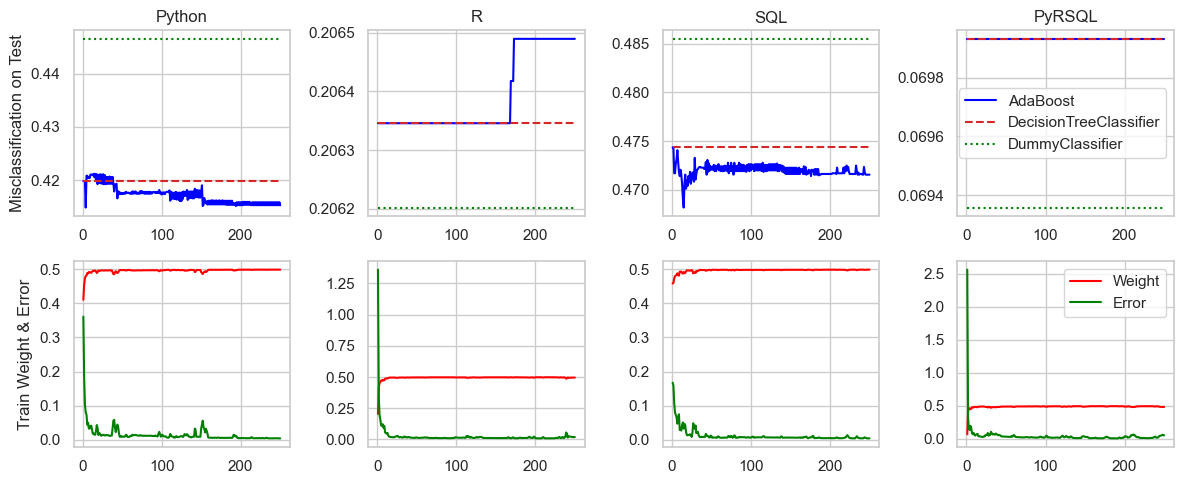

In [31]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,5))
ax[0,0].set_ylabel("Misclassification on Test")
ax[0,0].set_title("Comparison of AdaBoost verses Dummy and Decision Tree")
plot_error(models_Boost[0][1], models_decision[0][1], models_dummy[0][1], 0)
plot_error(models_Boost[1][1], models_decision[1][1], models_dummy[1][1], 1)
plot_error(models_Boost[2][1], models_decision[2][1], models_dummy[2][1], 2)
plot_error(models_Boost[3][1], models_decision[3][1], models_dummy[3][1], 3)

plot_clf_stats(models_Boost[0][0],0)
plot_clf_stats(models_Boost[1][0],1)
plot_clf_stats(models_Boost[2][0],2)
plot_clf_stats(models_Boost[3][0],3)
ax[1,0].set_ylabel("Train error")
ax[1,0].set_ylabel("Train Weight & Error")
ax[0,3].legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=0)
ax[1,3].legend(["Weight", "Error"], loc=1)
ax[0,0].set_title("Python")
ax[0,1].set_title("R")
ax[0,2].set_title("SQL")
ax[0,3].set_title("PyRSQL")

plt.tight_layout()

The image is a set of graphs from script, which has trained AdaBoost models to predict whether respondents have worked with Python, R, SQL, or all three (PyRSQL), based on features like years of coding, years of professional coding, total compensation, age, and yearly converted compensation.

The upper row of graphs displays the misclassification rates on the test set for AdaBoost, Decision Tree Classifier, and Dummy Classifier for each language category. The AdaBoost's performance changes over 250 iterations are shown in blue, with the red dashed line indicating the Decision Tree's misclassification rate and the green dotted line representing the Dummy Classifier's rate.

The bottom row of graphs shows the error rates and weights of the AdaBoost model's weak learners during training. In red is the error rate, which ideally decreases as the model learns, and in green is the weight of each learner, reflecting its importance in the ensemble.

The AdaBoost classifier seems to have a lower misclassification rate compared to the baseline models in all cases, indicating its effectiveness. The Decision Tree's performance is relatively stable across iterations. The Dummy Classifier's performance is constant since it makes random predictions and does not learn.

The AdaBoost model's training error decreases and stabilizes quickly, suggesting that the ensemble of weak learners is effective at reducing overall error. The weights of the weak learners also appear to stabilize, implying that the model's learning reaches a plateau where additional weak learners contribute less to improving the model's performance.

### **4.8** Comparative Confusion Matrix Visualization

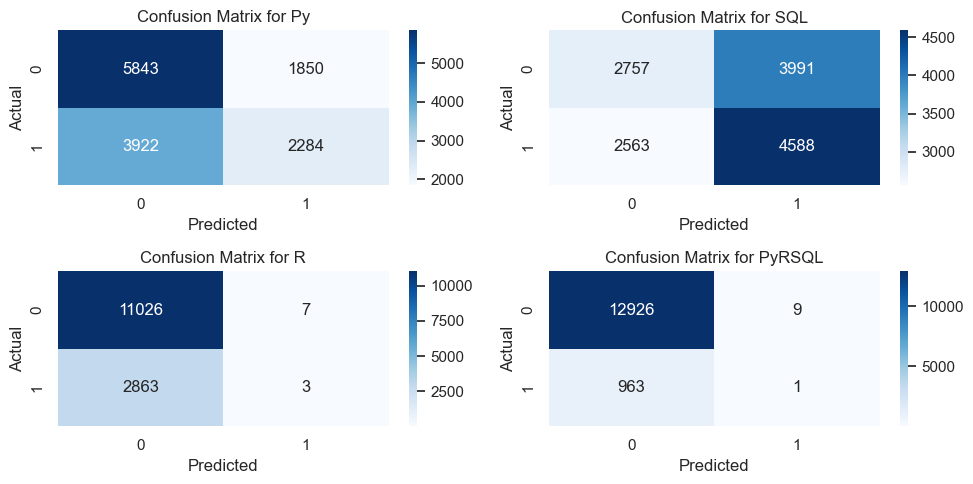

In [28]:
j = 0
l = 1
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

for i in models_Boost:
    if (j) // 2 != 0: 
        k = 1
        if j % 2 == 0:
            l = 0
        else:
            l = 1
    else: 
        k = 0
        if j == 0:
            l = 0
        else:
            l = 1

    y_pred = models_Boost[j][0].predict(X_test_Boost)

    # Create confusion matrix
    cm = confusion_matrix(models_Boost[j][3], y_pred)

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax[l][k])
    ax[l][k].set_xlabel('Predicted')  # Use set_xlabel instead of xlabel
    ax[l][k].set_ylabel('Actual')     # Use set_ylabel instead of ylabel
    ax[l][k].set_title(f'Confusion Matrix for {y_Boost_list[j]}')  # Use set_title instead of title
    j += 1 


plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

The four confusion matrices resulting from the predictions of AdaBoost models for different datasets labeled Py, SQL, R, and PyRSQL. These matrices illustrate the number of correct and incorrect predictions made by the models:

Python (Py): The model demonstrates moderate predictive ability, with a substantial number of true positives and negatives but also a notable amount of false predictions.

SQL: Similar to the Py model, this matrix indicates a balanced performance with a significant number of correct predictions, yet with

false predictions present.

R: This model shows a high number of true negatives and a low number of true positives, suggesting it's better at predicting non-R users.

PyRSQL: Dominated by true negatives, the model rarely predicts positive cases, suggesting a potential imbalance in the data or a conservative prediction bias.

### **4.9** Visualizing Boosted Model Predictions

<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>

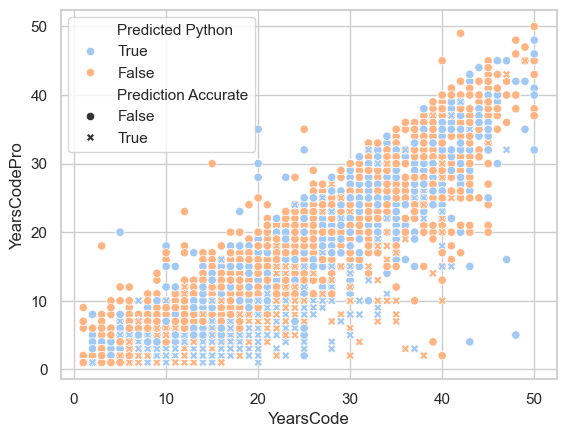

In [51]:
predicted_values = pd.DataFrame(models_Boost[0][3])
true_values = pd.DataFrame(y_pred_boost)

# Convert predicted and true values to strings for comparison
predicted_values_str = predicted_values.apply(lambda x: 'True' if x.iloc[0] == 1 else 'False', axis=1)
true_values_str = true_values.apply(lambda x: 'True' if x.iloc[0] == 1 else 'False', axis=1)

# Create DataFrame for style
style = pd.DataFrame()
style['Predicted Python'] = predicted_values_str
style['Prediction Accurate'] = true_values_str

# Plot with style
sns.scatterplot(x=X_test_Boost_s['YearsCode'], y=X_test_Boost_s['YearsCodePro'], 
                hue=style['Predicted Python'], style=style['Prediction Accurate'])


The scatter plot compares the number of years of coding experience (YearsCode) against the number of years of professional coding experience (YearsCodePro). The data points are colored and marked to differentiate between whether the the model accurately categorized the language as Python based on the age, compensation and experience of the programmer. The classes represent whether this categorization was correct. We can see that it is only correct around 60% of the time indicating that the language used is not totally dependent on these attributes.

From the scatter plot, we observe a distribution of individuals across a range of experience, from beginners to those with up to 50 years of coding experience. It appears that as the number of years of general coding experience increases, the years of professional coding experience also increase, which is an expected trend. There is considerable overlap between the two classes, suggesting that the distinction between the classes is not solely based on the number of years coded professionally or overall.

# **5**. Synthesis of Inference and Prediction

**Drawing Insights from Model Findings**
Through the application of logistic regression, random forest, and AdaBoost models, this project has endeavored to uncover the nuances of programming language preferences among developers, as influenced by their age and experience level. Each model provided a unique lens through which to view our data, yielding insights that, when combined, offer a multifaceted understanding of developer preferences.

The **logistic regression model** highlighted significant predictors among demographic features, particularly pointing out how age groups and experience levels are differentially associated with the likelihood of preferring certain programming languages. For instance, younger developers showed a pronounced preference for Python, aligning with its reputation as an accessible and widely-taught language in educational settings. This inference underlines the role of early exposure and community support in shaping language preferences.

In contrast, the **random forest model** illuminated the predictive relationships within our data, identifying complex patterns that single-variable analysis might miss. Its performance underscored the multifactorial nature of programming language preference, suggesting that while age and experience are influential, other factors, possibly including work environment, project requirements, and personal interests, also play critical roles.

The **AdaBoost model**, through its focus on improving prediction by combining weak learners, further refined our understanding of these dynamics. Its analysis revealed how combinations of features, including but not limited to demographic characteristics, contribute to the prediction of language preferences. Notably, the AdaBoost model's ability to adjust weights dynamically offered a nuanced view of which factors become more salient under different conditions.

**<ins>Key Insights:</ins>**

**Age-Specific Preferences:** There's a clear trend of younger developers gravitating towards languages known for their simplicity and community support, such as Python. This could inform educational strategies and community initiatives aimed at supporting early-career developers.

**Experience-Driven Diversification:** As developers gain more experience, their language preferences diversify, reflecting a broader engagement with the field's complexities and the demands of different projects. This diversification stresses the importance of continuous learning and adaptability in the developer's career.

**Predictive Complexity:** The predictive modeling emphasized the complex interplay of factors influencing language preference, beyond just age and experience. This complexity highlights the personalized nature of language learning and adoption, suggesting that industry and education policies should account for a wide range of influences.

The findings from this analysis suggest that programming language preference is influenced by a combination of demographic factors, exposure, and professional requirements. Understanding these dynamics can inform educational strategies, community support initiatives, and future research, particularly in adapting to evolving technological landscapes and emerging languages. Further exploration could consider additional variables and longitudinal studies to track preference trends over time, offering deeper insights into the evolving preferences of the developer community.

# **6**. Conclusion

This project embarked on an exploration of how programming language preferences vary among developers across different age groups and experience levels. Our findings underscore a dynamic interplay between demographic factors, professional exposure, and evolving industry trends in shaping these preferences. Notably, early exposure to accessible languages like Python plays a significant role in preference formation among younger developers, while experienced developers show a diversified language portfolio reflective of their complex project engagements.

The use of logistic regression, random forest, and AdaBoost models revealed not only the predictive significance of demographic factors but also the complexity of the underlying relationships influencing language choice. This complexity highlights the personalized nature of language learning and selection, influenced by a blend of professional, personal, and community factors.

Future research could expand this exploration by incorporating additional variables, employing longitudinal data, and considering the impact of emerging technologies on developer preferences. As the tech landscape continues to evolve, understanding these preferences will become increasingly important for educational initiatives, tool development, and community support strategies aimed at nurturing a skilled, adaptable developer workforce.